In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy.polynomial import Polynomial
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
import itertools




path = r"./DataPart5.csv"
df = pd.read_csv(path)

print(df.head())

x = df["x"].values


          x
0  0.000000
1  0.000000
2  0.043702
3  0.244185
4  0.228373


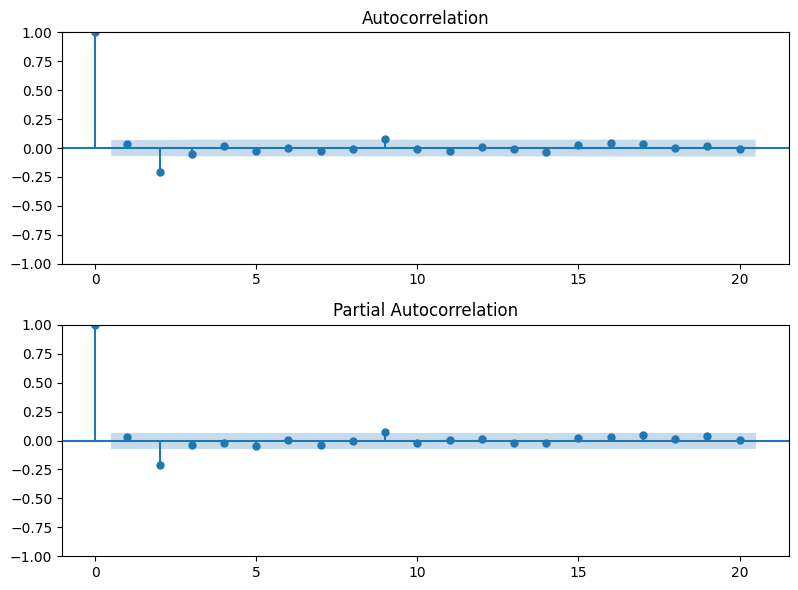

In [7]:
# Plotting ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(8,6))
plot_acf(x, lags=20, ax=ax[0])
plot_pacf(x, lags=20, ax=ax[1])
plt.tight_layout()
plt.show()

In [ ]:
# AR(p), MA(q), the d is the order of differencing
# ARIMA(p, d, q) )
model = ARIMA(x, order=(0,0,2))  
res = model.fit()

print(res.summary())

# The plots show a single significant negative spike at lag 2 in both ACF/PACF, while every other lag is within the bands.
# The ACF cuts off at lag 2, which is most consistent with an MA(2) process.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  800
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1707.826
Date:                Thu, 02 Oct 2025   AIC                           3423.653
Time:                        18:18:53   BIC                           3442.391
Sample:                             0   HQIC                          3430.851
                                - 800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2343      0.065     34.582      0.000       2.108       2.361
ma.L1          0.0144      0.039      0.370      0.711      -0.062       0.090
ma.L2         -0.2094      0.035     -5.958      0.0

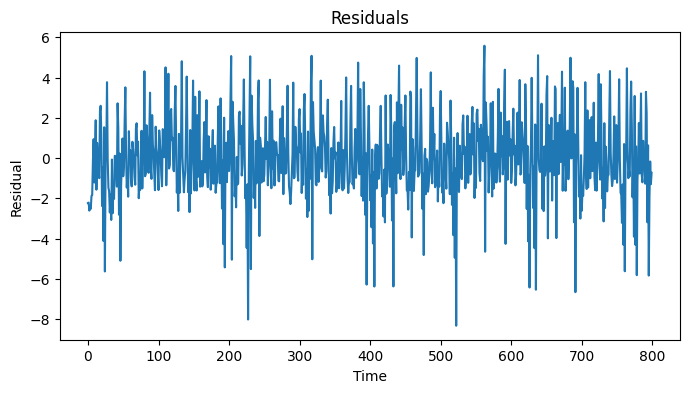

In [9]:
# Residual Analysis for ARMA(1,0)

residuals = res.resid

plt.figure(figsize=(8,4))
plt.plot(residuals)
plt.title("Residuals")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()


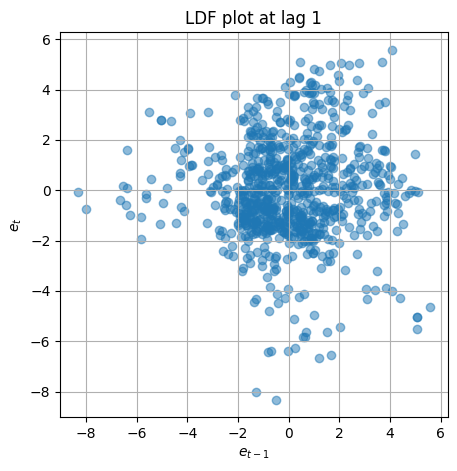

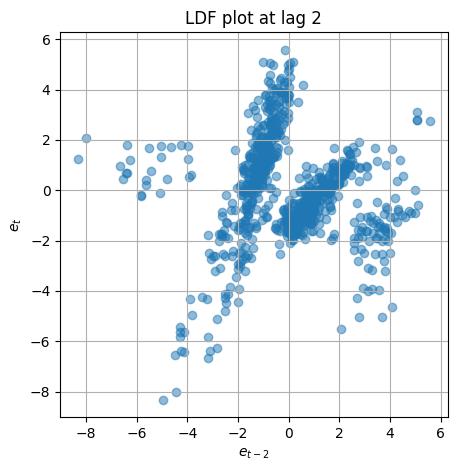

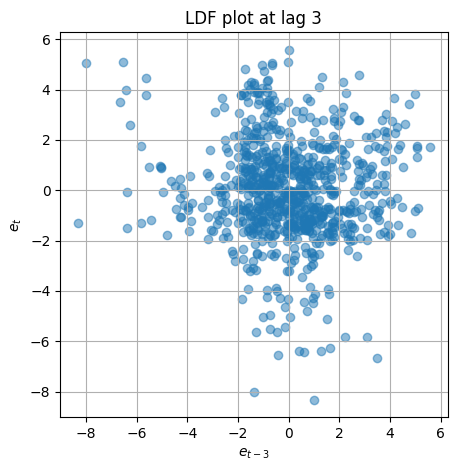

In [10]:
# Lag depended function

def ldf_plot(residuals, lag=1):
    e_t = residuals[lag:]
    e_t_lag = residuals[:-lag]
    
    plt.figure(figsize=(5,5))
    plt.scatter(e_t_lag, e_t, alpha=0.5)
    plt.xlabel(f"$e_{{t-{lag}}}$")
    plt.ylabel("$e_t$")
    plt.title(f"LDF plot at lag {lag}")
    plt.grid(True)
    plt.show()

# Lag plots for lag 1, 2 and 3
for lag in [1, 2, 3]:
    ldf_plot(residuals, lag)


In [11]:
# Grid search for best (p,q) based on AIC and BIC
p = range(0, 5)   # AR 
q = range(0, 5)   # MA 
orders = list(itertools.product(p, q))

results = []

for (pi, qi) in orders:
    try:
        model = ARIMA(x, order=(pi,0,qi))
        res = model.fit()
        results.append(((pi, qi), res.aic, res.bic))
    except Exception as e:
        warnings.warn(str(e))
        continue

# Put into DataFrame
results_df = pd.DataFrame(results, columns=["(p,q)", "AIC", "BIC"])
results_df = results_df.sort_values(by="AIC").reset_index(drop=True)

# Sort by AIC
results_df_aic = results_df.sort_values(by="AIC").reset_index(drop=True)
print("Top 5 models by AIC:")
print(results_df_aic.head())

# Sort by BIC
results_df_bic = results_df.sort_values(by="BIC").reset_index(drop=True)
print("\nTop 5 models by BIC:")
print(results_df_bic.head())



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Top 5 models by AIC:
    (p,q)          AIC          BIC
0  (2, 4)  3421.449170  3458.926064
1  (0, 3)  3422.083079  3445.506138
2  (1, 2)  3422.714346  3446.137404
3  (2, 0)  3422.792394  3441.530841
4  (2, 1)  3423.215357  3446.638415

Top 5 models by BIC:
    (p,q)          AIC          BIC
0  (2, 0)  3422.792394  3441.530841
1  (0, 2)  3423.652957  3442.391404
2  (0, 3)  3422.083079  3445.506138
3  (1, 2)  3422.714346  3446.137404
4  (2, 1)  3423.215357  3446.638415


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


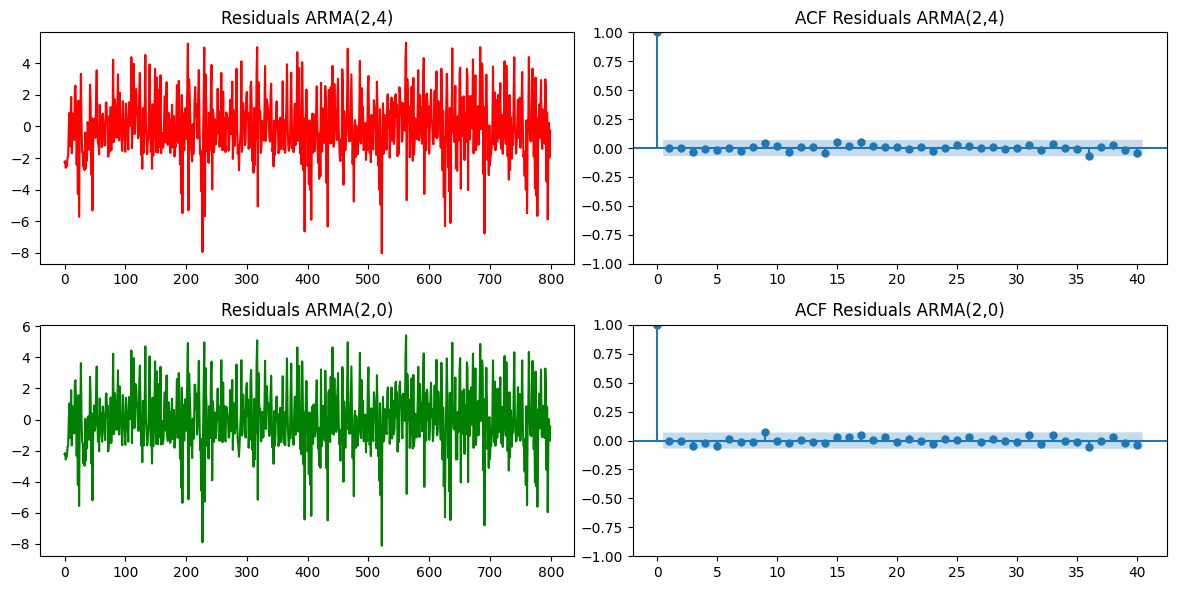

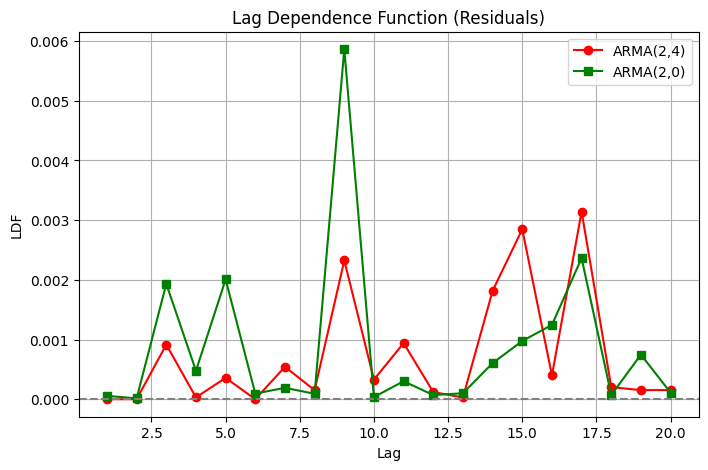

In [12]:
# ARMA(2,4) 
model_24 = ARIMA(x, order=(2,0,4))
res_24 = model_24.fit()
resid_24 = res_24.resid  # residuals

# Fit ARMA(2,0)
model_20 = ARIMA(x, order=(2,0,0))
res_20 = model_20.fit()
resid_20 = res_20.resid  # residuals

# Simple LDF function
def ldf_basic(x, lags):
    vals = []
    for k in lags:
        y = x[k:]
        xk = x[:-k]
        rss = np.sum((y - np.mean(y))**2)
        # Fit simple linear regression y ~ xk
        coef = np.polyfit(xk, y, 1)
        yhat = np.polyval(coef, xk)
        rss_k = np.sum((y - yhat)**2)
        vals.append((rss - rss_k) / rss)
    return np.array(vals)

# Lags to compute
lags = range(1, 21)

# Compute LDFs
ldf_24 = ldf_basic(resid_24, lags)
ldf_20 = ldf_basic(resid_20, lags)

# Residual and ACF plots
fig, axes = plt.subplots(2, 2, figsize=(12,6))

axes[0,0].plot(resid_24, color="red")
axes[0,0].set_title("Residuals ARMA(2,4)")

plot_acf(resid_24, lags=40, ax=axes[0,1])
axes[0,1].set_title("ACF Residuals ARMA(2,4)")

axes[1,0].plot(resid_20, color="green")
axes[1,0].set_title("Residuals ARMA(2,0)")

plot_acf(resid_20, lags=40, ax=axes[1,1])
axes[1,1].set_title("ACF Residuals ARMA(2,0)")

plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(8,5))
plt.plot(lags, ldf_24, 'o-r', label="ARMA(2,4)")
plt.plot(lags, ldf_20, 's-g', label="ARMA(2,0)")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Lag Dependence Function (Residuals)")
plt.xlabel("Lag")
plt.ylabel("LDF")
plt.legend()
plt.grid(True)
plt.show()




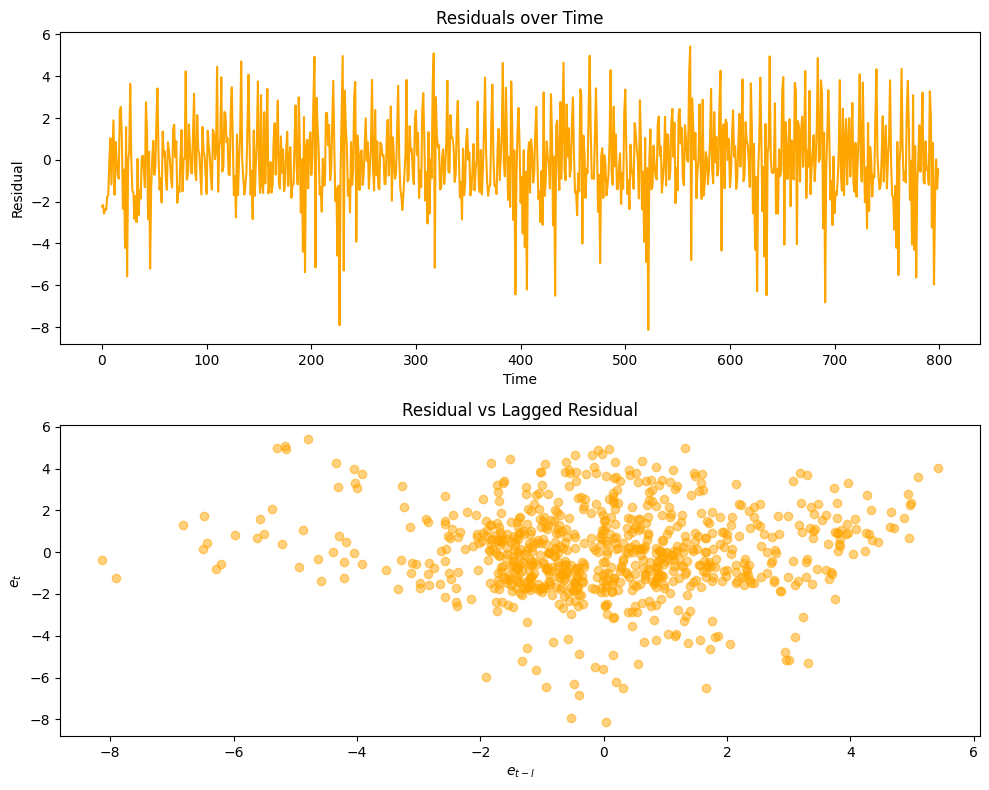

      lb_stat  lb_pvalue
10   8.504153   0.579716
20  13.700261   0.845362


In [13]:

# Fit ARMA(2,0)
arma20 = ARIMA(x, order=(2,0,0)).fit()

# Residuals
resid = arma20.resid

# --- Residual Analysis Plots ---
fig, axes = plt.subplots(2, 1, figsize=(10,8))

# Residuals over time
axes[0].plot(resid, color="orange")
axes[0].set_title("Residuals over Time")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Residual")

# Residual vs lagged residual (nonlinearity check)
axes[1].scatter(resid[1:], resid[:-1], alpha=0.5, color="orange")
axes[1].set_title("Residual vs Lagged Residual")
axes[1].set_xlabel(f"$e_{{t-l}}$")
axes[1].set_ylabel("$e_t$")

plt.tight_layout()
plt.show()

# --- Ljung-Box test for whiteness ---
lb_test = acorr_ljungbox(resid, lags=[10,20], return_df=True)
print(lb_test)

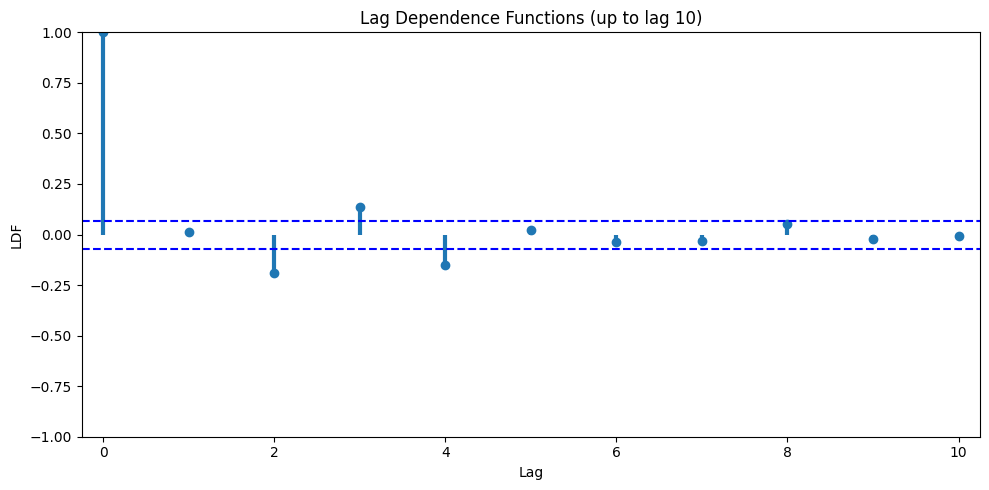

In [14]:
e = resid

# LDF(k) = corr(e_t, e_{t-k}^2), k = 1..max_lag
def ldf(residuals, max_lag=20):
    vals = []
    for k in range(1, max_lag+1):
        et  = residuals[k:]
        esk = residuals[:-k]**2
        vals.append(np.corrcoef(et, esk)[0,1])
    return np.array(vals)

max_lag = 10
ldf_vals = ldf(e, max_lag=max_lag)

# From lag 1 til 10
lags = np.arange(0, max_lag+1)                      # include 0
vals = np.concatenate([[1.0], ldf_vals[:max_lag]])  # set lag-0 = 1 by convention

plt.figure(figsize=(10,5))
plt.vlines(lags, 0, vals, linewidth=3)  # stems
plt.plot(lags, vals, 'o')               # markers

# Add significance band (approximate 95%)
n = len(e) - lags - 3
crit = np.tanh(1.96/np.sqrt(n))
plt.axhline(-crit.min(), linestyle="--", color="blue")
plt.axhline( crit.min(), linestyle="--", color="blue")

plt.title("Lag Dependence Functions (up to lag 10)")
plt.xlabel("Lag")
plt.ylabel("LDF")
plt.ylim(-1, 1)
plt.xlim(-0.25, max_lag + 0.25)
plt.tight_layout()
plt.show()


In [15]:
# AR(2) + GARCH(1,1) without the 'arch' package

# -------------------------
# 3) Fit GARCH(1,1) to eps by QMLE
#     sigma_t^2 = w + a*eps_{t-1}^2 + b*sigma_{t-1}^2
# -------------------------
def garch11_negloglik(theta, e):
    w, a, b = theta
    # enforce positivity & stationarity via penalty
    if w <= 0 or a < 0 or b < 0 or (a + b) >= 0.999:
        return 1e12  # large penalty

    n = len(e)
    s2 = np.empty(n)
    s2[0] = np.var(e)  # initialize
    for t in range(1, n):
        s2[t] = w + a * (e[t-1]**2) + b * s2[t-1]

    # Gaussian QMLE
    ll = -0.5*(np.log(2*np.pi) + np.log(s2) + (e**2)/s2)
    return -np.sum(ll)  # minimize negative log-likelihood

# Reasonable starting values
w0 = 0.1 * np.var(resid)
a0 = 0.05
b0 = 0.90

res_opt = minimize(
    garch11_negloglik,
    x0=np.array([w0, a0, b0]),
    args=(resid,),
    method="L-BFGS-B",
    # bounds keep params in admissible region (sum<1 handled by penalty)
    bounds=[(1e-12, None), (0.0, 0.999), (0.0, 0.999)],
    options={"maxiter": 2000}
)

w_hat, a_hat, b_hat = res_opt.x
print("\nGARCH(1,1) estimates (QMLE):")
print(f"omega = {w_hat:.6g}, alpha = {a_hat:.6g}, beta = {b_hat:.6g}, alpha+beta = {a_hat+b_hat:.6g}")

# Recompute conditional variance & standardized residuals with estimated params
n = len(resid)
sigma2 = np.empty(n)
sigma2[0] = np.var(resid)
for t in range(1, n):
    sigma2[t] = w_hat + a_hat*(resid[t-1]**2) + b_hat*sigma2[t-1]
sigma = np.sqrt(sigma2)
z = resid / sigma  # standardized residuals


# (a) Series and conditional volatility
plt.figure(figsize=(10,4))
plt.plot(x, label="Series")
plt.plot(sigma, label="Conditional volatility")
plt.title("AR(2) + GARCH(1,1): Series and Conditional Volatility")
plt.xlabel("Time"); plt.legend(); plt.tight_layout(); plt.show()

# (b) Standardized residuals over time
plt.figure(figsize=(10,4))
plt.plot(z)
plt.title("Standardized Residuals (AR(2)–GARCH(1,1))")
plt.xlabel("Time"); plt.tight_layout(); plt.show()

# (c) Standardized residual vs lagged (nonlinearity check)
plt.figure(figsize=(6,5))
plt.scatter(z[1:], z[:-1], alpha=0.5)
plt.title("Standardized Residual vs Lagged")
plt.xlabel("z(t-1)"); plt.ylabel("z(t)")
plt.tight_layout(); plt.show()

# (d) Ljung–Box on squared standardized residuals (should be insignificant)
lb = acorr_ljungbox(z**2, lags=[10, 20], return_df=True)
print("\nLjung–Box on squared standardized residuals:")
print(lb)

# (e) LDF: corr(z_t, z_{t-k}^2) up to lag 20
def ldf_corr_e_vs_sqelag(residuals, max_lag=20):
    vals = []
    for k in range(1, max_lag+1):
        et = residuals[k:]
        esk = residuals[:-k]**2
        vals.append(np.corrcoef(et, esk)[0,1])
    return np.array(vals)

max_lag = 20
ldf_vals = ldf_corr_e_vs_sqelag(z, max_lag=max_lag)
lags = np.arange(1, max_lag+1)

plt.figure(figsize=(10,4))
plt.bar(lags, ldf_vals)
plt.axhline(0, linewidth=1)
plt.title("LDF of Standardized Residuals: corr(z_t, z_{t-k}^2)")
plt.xlabel("Lag k"); plt.ylabel("Correlation")
plt.tight_layout(); plt.show()

# Optional: ACF-style 'stem' LDF up to lag 10 (like your earlier figure)
max_lag_show = 10
lags2 = np.arange(0, max_lag_show+1)
vals2 = np.concatenate([[1.0], ldf_vals[:max_lag_show]])
plt.figure(figsize=(10,4))
plt.vlines(lags2, 0, vals2, linewidth=3)
plt.plot(lags2, vals2, 'o')
# simple ~95% band using Fisher z (use min across lags for visual reference)
n_eff = len(z) - lags2 - 3
crit = np.tanh(1.96/np.sqrt(np.maximum(n_eff, 5)))  # guard small denom
plt.axhline(-crit[1:].min(), linestyle="--")
plt.axhline( crit[1:].min(), linestyle="--")
plt.title("Lag Dependence Functions (stems, up to lag 10)")
plt.xlabel("Lag"); plt.ylabel("LDF")
plt.ylim(-1, 1); plt.xlim(-0.25, max_lag_show + 0.25)
plt.tight_layout(); plt.show()


NameError: name 'minimize' is not defined